# "LOO-CV on transformed data"
> Can different transformations of the data be compared with leave one out cross validation?

- toc: true 
- author: Oriol Abril
- badges: true
- categories: [arviz, model comparison]
- image: images/nb/loo_regression.png

Comments are not enabled for the blog, to inquiry further about the contents of the post, ask on [ArviZ Issues](https://github.com/arviz-devs/arviz/issues) or [Stan Discourse](https://discourse.mc-stan.org/)

Blog post exploring whether or not LOO-CV can be used to compare models that try to explain some data $y$ with models trying to explain the same data after a transformation $z=f(y)$. Inspired by [@tiagocc question](https://discourse.mc-stan.org/t/very-simple-loo-question/9258) on Stan Forums. This post has two sections, the first one is the mathematical derivation of the equations used and their application on a validation example, and the second section is a real example. In addition to the LOO-CV usage examples and explanations, another goal of this notebook is to show and highlight the capabilities of [ArviZ](https://arviz-devs.github.io/arviz/).

This post has been automatically generated from a Jupyter notebook that can be downloaded [here]({{ site.url }}/notebooks/loo/LOO-CV_transformed_data.ipynb)

In [1]:
import pystan
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [2]:
az.style.use("arviz-darkgrid")

## Mathematical derivation and validation example
In the first example, we will compare two equivalent models: 

1. $y \sim \text{LogNormal}(\mu, \sigma)$
2. $\log y \sim \text{Normal}(\mu, \sigma)$

### Model definition and execution
Define the data and execute the two models

In [3]:
mu = 2
sigma = 1
logy = np.random.normal(loc=mu, scale=sigma, size=30)
y = np.exp(logy) # y will then be distributed as lognormal
data = {
    'N': len(y),      
    'y': y,
    'logy': logy
}

In [4]:
#collapse-hide
lognormal_code = """
data {
  int<lower=0> N;
  vector[N] y;
}

parameters {
  real mu;
  real<lower=0> sigma;
}

model {
    y ~ lognormal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;
    vector[N] y_hat;

    for (i in 1:N) {
        log_lik[i] = lognormal_lpdf(y[i] | mu, sigma);
        y_hat[i] = lognormal_rng(mu, sigma);
    }
}

"""

In [5]:
sm_lognormal = pystan.StanModel(model_code=lognormal_code)
fit_lognormal = sm_lognormal.sampling(data=data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af04dcd0464f65fe0e5bbc595b4eb9d6 NOW.


In [6]:
idata_lognormal = az.from_pystan(
    posterior=fit_lognormal,
    posterior_predictive='y_hat',
    observed_data=['y'],
    log_likelihood={'y': 'log_lik'},
)

In [7]:
#collapse-hide
normal_on_log_code = """
data {
  int<lower=0> N;
  vector[N] logy;
}

parameters {
  real mu;
  real<lower=0> sigma;
}

model {
    logy ~ normal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;
    vector[N] logy_hat;

    for (i in 1:N) {
        log_lik[i] = normal_lpdf(logy[i] | mu, sigma);
        logy_hat[i] = normal_rng(mu, sigma);
    }
}
"""

In [8]:
sm_normal = pystan.StanModel(model_code=normal_on_log_code)
fit_normal = sm_normal.sampling(data=data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_acd7c874588f1c862727f931f4dbf916 NOW.


In [9]:
idata_normal = az.from_pystan(
    posterior=fit_normal,
    posterior_predictive='logy_hat',
    observed_data=['logy'],
    log_likelihood={'logy': 'log_lik'},
)

Check model convergence. Use `az.summary` to in one view that the effective sample size (ESS) is large enough and $\hat{R}$ is close to one.

In [10]:
az.summary(idata_lognormal)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,2.193,0.199,1.832,2.577,0.005,0.004,1353.0,1350.0,1360.0,1374.0,1.0
sigma,1.112,0.157,0.844,1.398,0.004,0.003,1314.0,1182.0,1559.0,1091.0,1.0


In [11]:
az.summary(idata_normal)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,2.196,0.209,1.805,2.590,0.006,0.004,1213.0,1189.0,1223.0,1054.0,1.0
sigma,1.112,0.154,0.861,1.401,0.005,0.003,1169.0,1107.0,1293.0,956.0,1.0


In addition, we can plot the quantile ESS plot for one of them directly with `plot_ess`

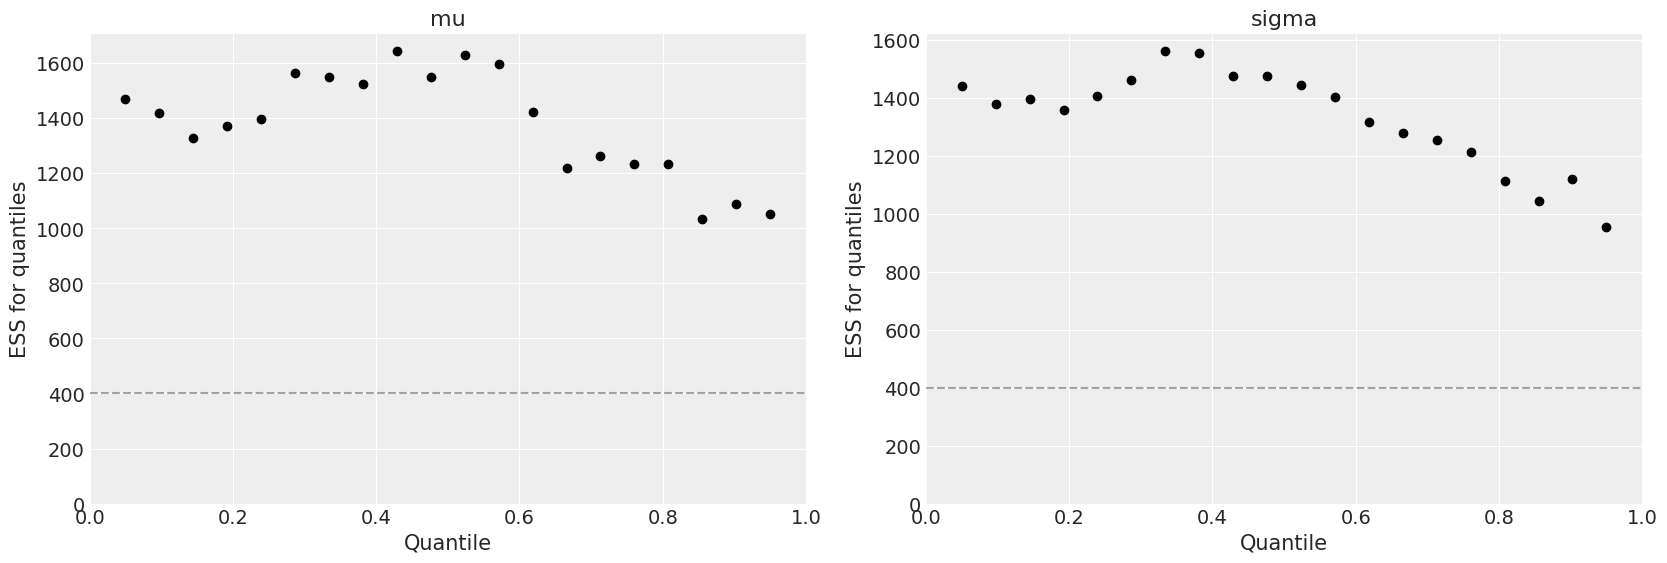

In [12]:
az.plot_ess(idata_normal, kind="quantile", color="k");

### Posterior validation
Check that both models are equivalent and do indeed give the same result for both parameters.

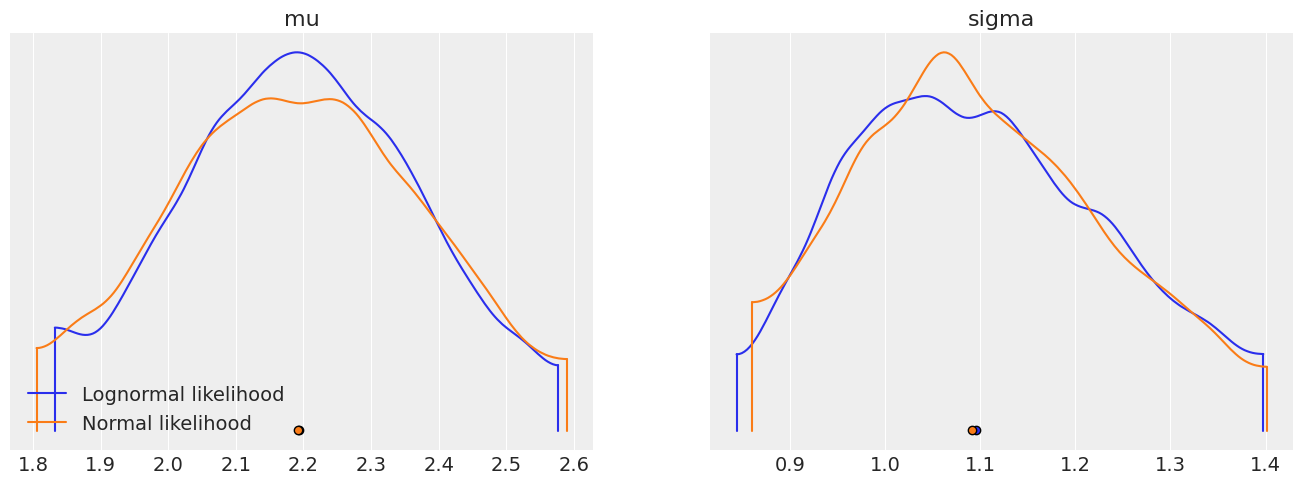

In [13]:
az.plot_density([idata_lognormal, idata_normal], data_labels=["Lognormal likelihood", "Normal likelihood"]);

### Calculate LOO-CV
Now we get to calculate LOO-CV using Pareto Smoothed Importance Sampling as detailed in Vehtari et al., 2017. As we explained above, both models are equivalent, but one is in terms of $y$ and the other in terms of $\log y$. Therefore, their likelihoods will be on different scales, and hence, their expected log predictive density will also be different.

In [14]:
az.loo(idata_lognormal)

Computed from 2000 by 30 log-likelihood matrix

         Estimate       SE
elpd_loo  -111.67     7.18
p_loo        2.14        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [15]:
az.loo(idata_normal)

Computed from 2000 by 30 log-likelihood matrix

         Estimate       SE
elpd_loo   -46.23     4.56
p_loo        2.22        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

We have found that as expected, the two models yield different results despite being actually the same model. This is because. LOO is estimated from the log likelihood, $\log p(y_i\mid\theta^s)$, being $i$ the observation id, and $s$ the MCMC sample id. Following Vehtari et al., 2017, this log likelihood is used to calculate the PSIS weights and to estimate the expected log pointwise predictive density in the following way:

1. Calculate raw importance weights: $r_i^s = \frac{1}{p(y_i\mid\theta^s)}$
2. Smooth the $r_i^s$ (see original paper for details) to get the PSIS weights $w_i^s$
3. Calculate elpd LOO as:

$$ \text{elpd}_{psis-loo} = \sum_{i=1}^n \log \left( \frac{\sum_s w_i^s p(y_i|\theta^s)}{\sum_s w_i^s} \right) $$

This will estimate the out of sample predictive fit of $y$ (where $y$ is the data of the model. Therefore, for the first model, using a LogNormal distribution, we are indeed calculating the desired quantity:

$$ \text{elpd}_{psis-loo}^{(1)} \approx \sum_{i=1}^n \log p(y_i|y_{-i}) $$

Whereas for the second model, we are calculating:

$$ \text{elpd}_{psis-loo}^{(2)} \approx \sum_{i=1}^n \log p(z_i|z_{-i}) $$

being $z_i = \log y_i$. We actually have two different probability density functions, one over $y$ which from here on we will note $p_y(y)$, and $p_z(z)$.

In order to estimate the elpd loo for $y$ from the data in the second model, $z$, we have to describe $p_y(y)$ as a function of $z$ and $p_z(z)$. We know that $y$ and $z$ are actually related, and we can use this relation to find how would the random variable $y$ (which is actually a transformation of the random variable $z$) be distributed. This is done with the Jacobian. Therefore:

$$
p_y(y|\theta)=p_z(z|\theta)|\frac{dz}{dy}|=\frac{1}{|y|}p_z(z|\theta)=e^{-z}p_z(z|\theta)
$$

In the log scale:

$$
\log p_y(y|\theta)=-z + \log p_z(z|\theta)
$$

We apply the results to the log likelihood data of the second model (the normal on the logarithm instead of the lognormal) and check that now the result does coincide with the LOO-CV estimated by the lognormal model.

In [16]:
z = logy
idata_normal.log_likelihood["y"] = -z+idata_normal.log_likelihood.logy

In [17]:
az.loo(idata_normal, var_name="y")

Computed from 2000 by 30 log-likelihood matrix

         Estimate       SE
elpd_loo  -111.75     7.18
p_loo        2.22        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

## Real example

We will now use as data a subsample of a [real dataset](https://docs.google.com/spreadsheets/d/1gt1Dvi7AnQJiBb5vKaxanTis_sfd4sC4sVoswM1Fz7s/pub#). The subset has been selected using:

```python
df = pd.read_excel("indicator breast female incidence.xlsx").set_index("Breast Female Incidence").dropna(thresh=20).T
df.to_csv("indicator_breast_female_incidence.csv")
```

Below, the data is loaded and plotted for inspection.

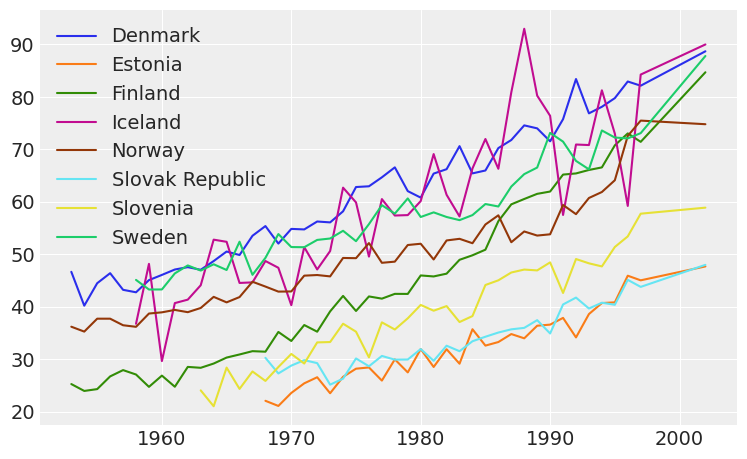

In [18]:
df = pd.read_csv("data/indicator_breast_female_incidence.csv", index_col=0)
df.plot(figsize=(9,5.5));

In order to show different examples of LOO on transformed data, we will take into account the following models:

$$
\begin{align}
&y=a_1 x+a_0 \\
&y=e^{b_0}e^{b_1 x}  &\rightarrow& \quad\log y = z_1 = b_1 x + b_0\\
&y=c_1^2 x^2 + 2 c_1 c_2 x + c_0^2  &\rightarrow& \quad\sqrt{y} = z_2 = c_1 x + c_0
\end{align}
$$

This models have been chosen mainly because of their simplicity. In addition, they can all be applied using the same Stan code and the data looks kind of linear. This will put the focus of the example on the loo calculation instead of on the model itself. For the online example, the data from Finland has been chosen, but feel free to download the notebook and experiment with it.

In [19]:
y_data = df.Finland
z1_data = np.log(y_data)
z2_data = np.sqrt(y_data)
x_data = df.index/100 # rescale to set both to a similar scale
dict_y = {"N": len(x_data), "y": y_data, "x": x_data}
dict_z1 = {"N": len(x_data), "y": z1_data, "x": x_data}
dict_z2 = {"N": len(x_data), "y": z2_data, "x": x_data}
coords = {"year": x_data}
dims = {"y": ["year"], "log_likelihood": ["year"]}

In [20]:
#collapse-hide
lr_code = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}

parameters {
  real b0;
  real b1;
  real<lower=0> sigma_e;
}

model {
  b0 ~ normal(0, 20);
  b1 ~ normal(0, 20);
  for (i in 1:N) {
    y[i] ~ normal(b0 + b1 * x[i], sigma_e);
  }

}

generated quantities {
    vector[N] log_lik;
    vector[N] y_hat;
    for (i in 1:N) {
        log_lik[i] = normal_lpdf(y[i] | b0 + b1 * x[i], sigma_e);
        y_hat[i] = normal_rng(b0 + b1 * x[i], sigma_e);
    }
}
"""

In [21]:
sm_lr = pystan.StanModel(model_code=lr_code)
control = {"max_treedepth": 15}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_01dac21720941a01839c67cf2ac4a0fc NOW.


In [22]:
fit_y = sm_lr.sampling(data=dict_y, iter=1500, chains=6, control=control)

In [23]:
fit_z1 = sm_lr.sampling(data=dict_z1, iter=1500, chains=6, control=control)

In [24]:
fit_z2 = sm_lr.sampling(data=dict_z2, iter=1500, chains=6, control=control)

In [25]:
idata_y = az.from_pystan(
    posterior=fit_y,
    posterior_predictive='y_hat',
    observed_data=['y'],
    log_likelihood={'y': 'log_lik'},
    coords=coords,
    dims=dims,
)
idata_y.posterior = idata_y.posterior.rename({"b0": "a0", "b1": "a1"})

In [26]:
idata_z1 = az.from_pystan(
    posterior=fit_z1,
    posterior_predictive='y_hat',
    observed_data=['y'],
    log_likelihood={'z1': 'log_lik'},
    coords=coords,
    dims=dims,
)

In [27]:
idata_z2 = az.from_pystan(
    posterior=fit_z2,
    posterior_predictive='y_hat',
    observed_data=['y'],
    log_likelihood={'z2': 'log_lik'},
    coords=coords,
    dims=dims,
)
idata_z2.posterior = idata_z2.posterior.rename({"b0": "c0", "b1": "c1"})

In order to compare the out of sample predictive accuracy, we have to apply the Jacobian transformation to the 2 latter models, so that all of them are in terms of $y$. 

Note: we will use LOO instead of Leave Future Out algorithm even though it may be more appropriate because the Jacobian transformation to be applied is the same in both cases. Moreover, PSIS-LOO does not require refitting, and it is already implemented in ArviZ.

The transformation to apply to the second model $z_1 = \log y$ is the same as the previous example:

In [28]:
idata_z1.log_likelihood["y"] = -z1_data.values+idata_z1.log_likelihood.z1

In the case of the third model, $z_2 = \sqrt{y}$:

$$ |\frac{dz}{dy}| = |\frac{1}{2\sqrt{y}}| = \frac{1}{2 z_2} \quad \rightarrow \quad \log |\frac{dz}{dy}| = -\log (2 z_2)$$

In [29]:
idata_z2.log_likelihood["y"] = -np.log(2*z2_data.values)+idata_z2.log_likelihood.z2

In [30]:
az.loo(idata_y)

Computed from 4500 by 46 log-likelihood matrix

         Estimate       SE
elpd_loo  -194.31     3.88
p_loo        1.64        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [31]:
print("LOO before Jacobian transformation: {:.2f}".format(az.loo(idata_z1, var_name="z1").loo))
print(az.loo(idata_z1, var_name="y"))

LOO before Jacobian transformation: 70.70
Computed from 4500 by 46 log-likelihood matrix

         Estimate       SE
elpd_loo  -100.30     4.41
p_loo        2.99        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.


In [32]:
print("LOO before Jacobian transformation: {:.2f}".format(az.loo(idata_z2, var_name="z2").loo))
print(az.loo(idata_z2, var_name="y"))

LOO before Jacobian transformation: 2.23
Computed from 4500 by 46 log-likelihood matrix

         Estimate       SE
elpd_loo  -115.15     3.83
p_loo        2.93        -

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.


## References
Vehtari, A., Gelman, A., and Gabry, J. (2017):  Practical Bayesian Model Evaluation Using Leave-One-OutCross-Validation and WAIC, _Statistics and Computing_, vol. 27(5), pp. 1413–1432.